## Objective

- Daily records of air pollutant concentrations collected over time, including PM2.5, PM10, NO₂, SO₂, CO, and Ozone. It also logs the Air Quality Index (AQI), along with date (day, month, year) also includes number of holidays and weekday representation.
- It is ideal for developing models to predict AQI, study pollution patterns, and analyze the effects of temporal or holiday factors on air quality.

#### Importing Libraries

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from scipy.stats import shapiro
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

#### File Reading

In [35]:
df = pd.read_csv("final_dataset.csv")

df["Date"] = pd.to_datetime(
    df[["Year", "Month", "Date"]].rename(columns={"Date": "Day"})
)

df = df.sort_values("Date").set_index("Date")
print(df.head())

            Month  Year  Holidays_Count  Days   PM2.5    PM10     NO2    SO2  \
Date                                                                           
2021-01-01      1  2021               0     5  408.80  442.42  160.61  12.95   
2021-01-02      1  2021               0     6  404.04  561.95   52.85   5.18   
2021-01-03      1  2021               1     7  225.07  239.04  170.95  10.93   
2021-01-04      1  2021               0     1   89.55  132.08  153.98  10.42   
2021-01-05      1  2021               0     2   54.06   55.54  122.66   9.70   

              CO  Ozone  AQI  
Date                          
2021-01-01  2.77  43.19  462  
2021-01-02  2.60  16.43  482  
2021-01-03  1.40  44.29  263  
2021-01-04  1.01  49.19  207  
2021-01-05  0.64  48.88  149  


#### Exploratory Data Analysis

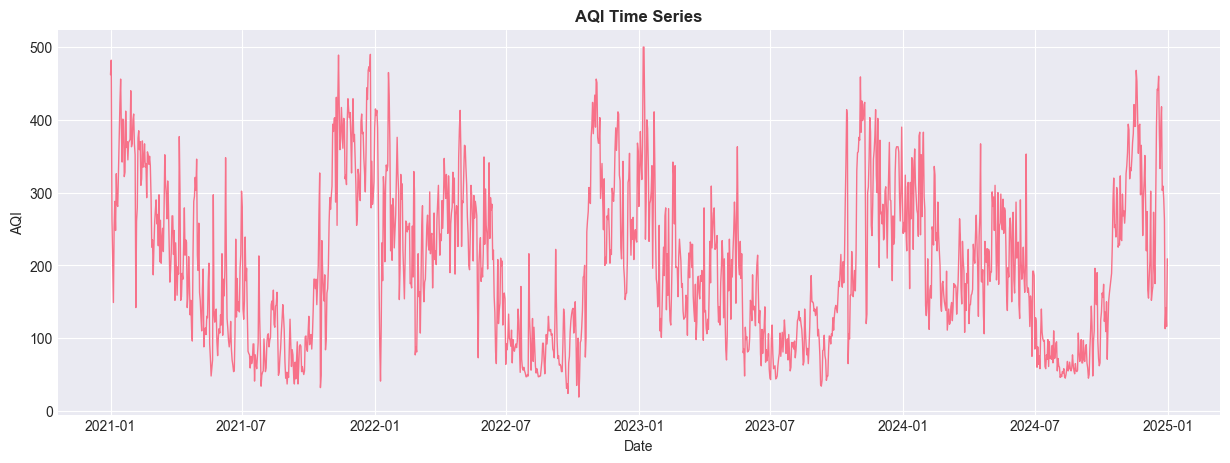

In [36]:
plt.figure(figsize=(15,5))
plt.plot(df.index, df["AQI"], linewidth=1)
plt.title("AQI Time Series", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.show()

Outliers detected: 0 (0.00%)


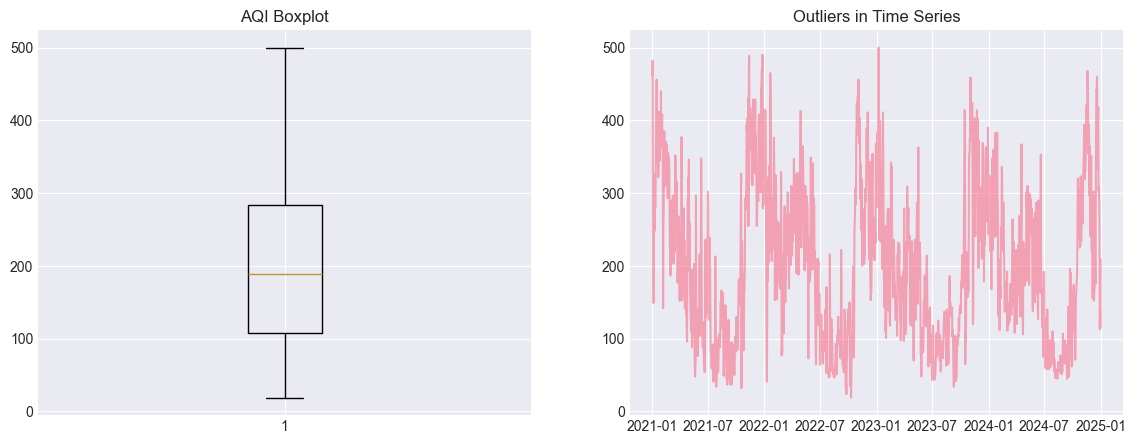

In [37]:
# outlier detection

Q1, Q3 = df["AQI"].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

z_scores = np.abs(stats.zscore(df["AQI"]))
outliers = (df["AQI"] < lower) | (df["AQI"] > upper) | (z_scores > 3)

print(f"Outliers detected: {outliers.sum()} ({outliers.mean()*100:.2f}%)")

fig, axes = plt.subplots(1, 2, figsize=(14,5))

axes[0].boxplot(df["AQI"])
axes[0].set_title("AQI Boxplot")

axes[1].plot(df.index, df["AQI"], alpha=0.6)
axes[1].scatter(df.index[outliers], df["AQI"][outliers], color="red", s=15)
axes[1].set_title("Outliers in Time Series")

plt.show()

In [38]:
df["AQI"] = np.clip(df["AQI"], lower, upper)

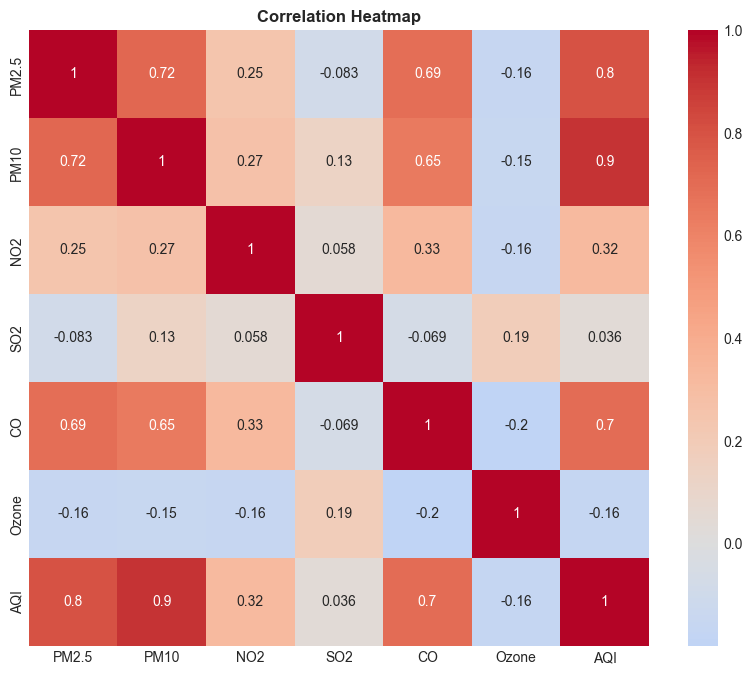

In [39]:
pollutants = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone", "AQI"]
corr = df[pollutants].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap", fontweight="bold")
plt.show()

In [40]:
series = df["AQI"]

test_size = 90
val_size = 60

train = series[:-test_size-val_size]
val = series[-test_size-val_size:-test_size]
test = series[-test_size:]

print(len(train), len(val), len(test))

1311 60 90


#### Statistical Data Analysis

In [41]:
adf_p = adfuller(train)[1]
d = 0 if adf_p < 0.05 else 1

print(f"ADF p-value = {adf_p:.4f} → d = {d}")

ADF p-value = 0.0010 → d = 0



 SEASONALITY TESTS
------------------------------------------------------------------------------------------


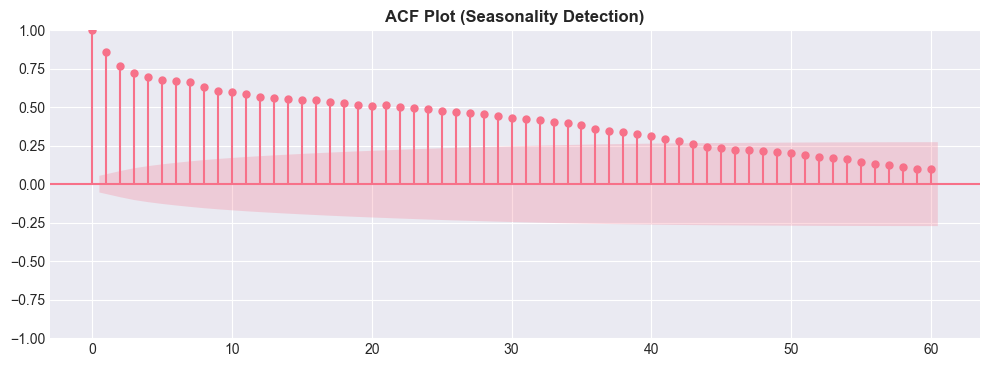

Rule of thumb:
• Significant spikes at lag 7 → weekly seasonality
• Significant spikes at lag 30 → monthly seasonality

Kruskal–Wallis Test (Weekly Seasonality):
Statistic: 0.3863
p-value: 0.9990
✗ No strong weekly seasonality detected

 AUTOCORRELATION TESTS
------------------------------------------------------------------------------------------
         lb_stat  lb_pvalue
10   6314.352915        0.0
20  10250.211052        0.0
30  13263.643854        0.0
✓ Autocorrelation detected → AR / SARIMA justified

 RANDOM WALK TEST
------------------------------------------------------------------------------------------
ADF p-value on ΔAQI: 0.0000
✗ Not a random walk (already stationary)

 HETEROSCEDASTICITY TESTS
------------------------------------------------------------------------------------------


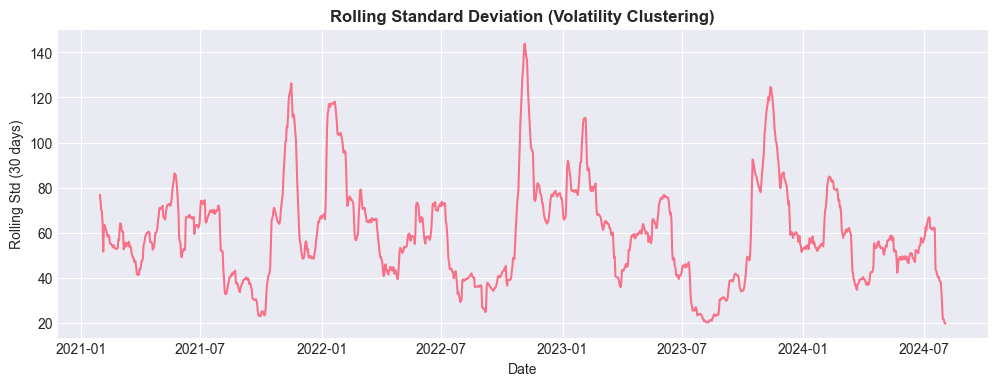

In [42]:
print("\n SEASONALITY TESTS")
print("-" * 90)

fig, ax = plt.subplots(figsize=(12,4))
plot_acf(train, lags=60, ax=ax)
ax.set_title("ACF Plot (Seasonality Detection)", fontweight="bold")
plt.show()

print("Rule of thumb:")
print("• Significant spikes at lag 7 → weekly seasonality")
print("• Significant spikes at lag 30 → monthly seasonality")
train_df = train.to_frame(name="AQI")
train_df["weekday"] = train_df.index.dayofweek

groups = [group["AQI"].values for _, group in train_df.groupby("weekday")]

kw_stat, kw_p = stats.kruskal(*groups)

print("\nKruskal–Wallis Test (Weekly Seasonality):")
print(f"Statistic: {kw_stat:.4f}")
print(f"p-value: {kw_p:.4f}")

if kw_p < 0.05:
    print("✓ Significant WEEKLY seasonality detected")
else:
    print("✗ No strong weekly seasonality detected")
print("\n AUTOCORRELATION TESTS")
print("-" * 90)

lb = acorr_ljungbox(train, lags=[10, 20, 30], return_df=True)
print(lb)

if (lb["lb_pvalue"] < 0.05).any():
    print("✓ Autocorrelation detected → AR / SARIMA justified")
else:
    print("✗ No significant autocorrelation")
print("\n RANDOM WALK TEST")
print("-" * 90)

adf_diff_p = adfuller(train.diff().dropna())[1]

print(f"ADF p-value on ΔAQI: {adf_diff_p:.4f}")

if adf_p > 0.05 and adf_diff_p < 0.05:
    print("✓ Strong evidence of RANDOM WALK")
elif adf_p < 0.05:
    print("✗ Not a random walk (already stationary)")
else:
    print("⚠ Inconclusive random walk behavior")
print("\n HETEROSCEDASTICITY TESTS")
print("-" * 90)

rolling_std = train.rolling(30).std()

plt.figure(figsize=(12,4))
plt.plot(rolling_std)
plt.title("Rolling Standard Deviation (Volatility Clustering)", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Rolling Std (30 days)")
plt.show()

#### Deep Learning Models - LSTM & GRU

In [43]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.values.reshape(-1,1))
val_scaled = scaler.transform(val.values.reshape(-1,1))
test_scaled = scaler.transform(test.values.reshape(-1,1))

In [44]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data)-seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

def create_val_sequences(train, val, seq_len):
    combined = np.vstack([train[-seq_len:], val])
    return create_sequences(combined, seq_len)

SEQ_LEN = 30

X_train, y_train = create_sequences(train_scaled, SEQ_LEN)
X_val, y_val = create_val_sequences(train_scaled, val_scaled, SEQ_LEN)
X_test, y_test = create_sequences(test_scaled, SEQ_LEN)

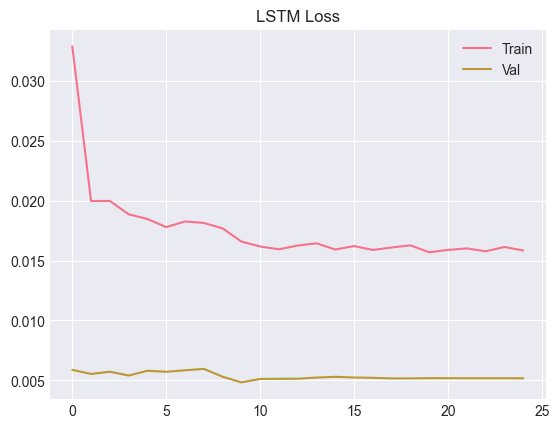

In [45]:
def build_lstm(units, dropout, lr):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(SEQ_LEN,1)),
        Dropout(dropout),
        LSTM(units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(lr), loss="mse")
    return model

lstm = build_lstm(64, 0.2, 0.001)

callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True),
    ReduceLROnPlateau(patience=5)
]

history = lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)

plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("LSTM Loss")
plt.legend()
plt.show()

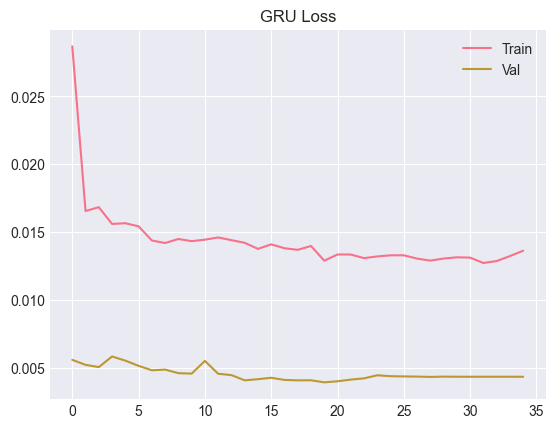

In [46]:
def build_gru(units, dropout, lr):
    model = Sequential([
        GRU(units, return_sequences=True, input_shape=(SEQ_LEN,1)),
        Dropout(dropout),
        GRU(units),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(lr), loss="mse")
    return model

gru = build_gru(64, 0.2, 0.001)

history = gru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32,
    callbacks=callbacks,
    verbose=0
)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("GRU Loss")
plt.legend()
plt.show()

#### Time Series Modelling

In [49]:
print("\n ARIMA SELECTION ")
print("-" * 60)

best_aic = np.inf
best_params = None

for p in range(8):
    for q in range(9):
        if p == 0 and q == 0:
            continue  # avoid pure random walk
        try:
            model = ARIMA(
                train,
                order=(p, d, q),
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            fit = model.fit()
            
            if np.isfinite(fit.aic) and fit.aic < best_aic:
                best_aic = fit.aic
                best_params = (p, d, q)

        except Exception as e:
            continue

# Fallback (GUARANTEED)
if best_params is None:
    print("⚠ All ARIMA fits failed — using fallback ARIMA(1,d,1)")
    best_params = (1, d, 1)

print(f"✓ Best ARIMA by AIC: {best_params}")


 ARIMA SELECTION 
------------------------------------------------------------
✓ Best ARIMA by AIC: (2, 0, 8)



ARIMA Forecast (first 10 values):
2024-08-04     70.918659
2024-08-05     80.647052
2024-08-06     87.429398
2024-08-07     90.874142
2024-08-08     89.077964
2024-08-09     94.069654
2024-08-10     94.701197
2024-08-11     98.395017
2024-08-12    101.002229
2024-08-13    103.067027
Freq: D, Name: predicted_mean, dtype: float64


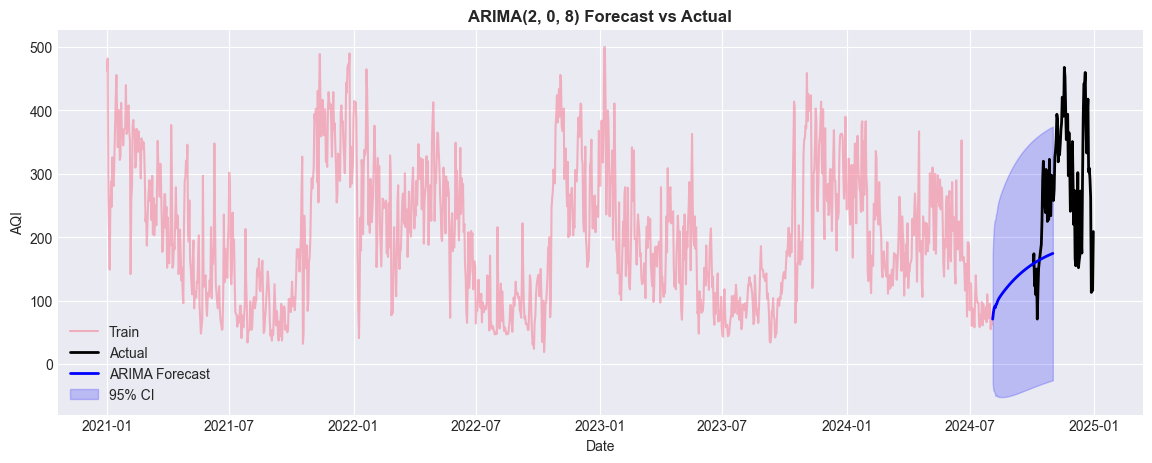

In [50]:
arima_model = ARIMA(
    train,
    order=best_params,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit()

arima_forecast = arima_model.get_forecast(len(test)).predicted_mean
print("\nARIMA Forecast (first 10 values):")
print(arima_forecast.head(10))

plt.figure(figsize=(14,5))
arima_fc_obj = arima_model.get_forecast(steps=len(test))
arima_forecast = arima_fc_obj.predicted_mean
arima_ci = arima_fc_obj.conf_int()
arima_pred = arima_fc_obj.predicted_mean.values
plt.plot(train.index, train, label="Train", alpha=0.5)
plt.plot(test.index, test, label="Actual", color="black", linewidth=2)

plt.plot(arima_forecast.index, arima_forecast,
         label="ARIMA Forecast", color="blue", linewidth=2)

plt.fill_between(
    arima_forecast.index,
    arima_ci.iloc[:, 0],
    arima_ci.iloc[:, 1],
    color="blue",
    alpha=0.2,
    label="95% CI"
)

plt.title(f"ARIMA{best_params} Forecast vs Actual", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()


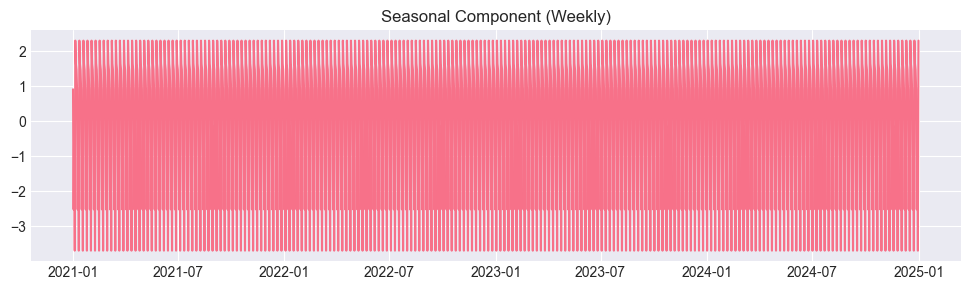

Seasonality strength: 0.020


In [51]:
series = df["AQI"].asfreq("D")
series = series.ffill()
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_period = 7  # weekly for daily AQI
decomp = seasonal_decompose(series, period=seasonal_period, model="additive")

plt.figure(figsize=(12,3))
plt.plot(decomp.seasonal)
plt.title("Seasonal Component (Weekly)")
plt.show()

seasonality_strength = decomp.seasonal.std() / series.std()
print(f"Seasonality strength: {seasonality_strength:.3f}")
D = 1 if seasonality_strength > 0.05 else 0

In [52]:
print("\n SARIMA SELECTION")
print("-" * 60)

best_aic = np.inf
best_order = None
best_seasonal = None

for p in range(8):
    for q in range(9):
        try:
            model = SARIMAX(
                train,
                order=(p, d, q),
                seasonal_order=(1, D, 1, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True
            )
            fit = model.fit(disp=False)

            if np.isfinite(fit.aic) and fit.aic < best_aic:
                best_aic = fit.aic
                best_order = (p, d, q)
                best_seasonal = (1, D, 1, seasonal_period)

        except Exception as e:
            continue

# Fallback safety
if best_order is None:
    print("⚠ All SARIMA fits failed — using fallback SARIMA(1,d,1)x(1,D,1,s)")
    best_order = (1, d, 1)
    best_seasonal = (1, D, 1, seasonal_period)

print(f"✓ Best SARIMA: {best_order} x {best_seasonal}")


 SARIMA SELECTION
------------------------------------------------------------
✓ Best SARIMA: (1, 0, 6) x (1, 0, 1, 7)


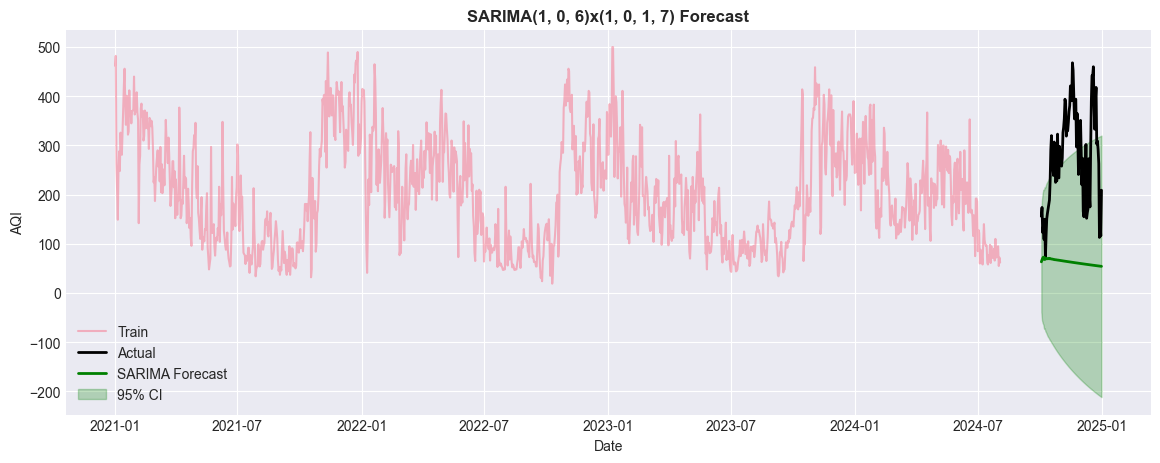

In [53]:
sarima_model = SARIMAX(
    train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True
).fit(disp=False)
sarima_fc = sarima_model.get_forecast(steps=len(test))
sarima_pred = sarima_fc.predicted_mean.values
sarima_forecast = sarima_fc.predicted_mean
sarima_ci = sarima_fc.conf_int()
sarima_forecast.index = test.index
sarima_ci.index = test.index
plt.figure(figsize=(14,5))

plt.plot(train.index, train, label="Train", alpha=0.5)
plt.plot(test.index, test, label="Actual", color="black", linewidth=2)

plt.plot(sarima_forecast.index, sarima_forecast,
         label="SARIMA Forecast", color="green", linewidth=2)

plt.fill_between(
    sarima_ci.index,
    sarima_ci.iloc[:, 0],
    sarima_ci.iloc[:, 1],
    color="green",
    alpha=0.25,
    label="95% CI"
)

plt.title(f"SARIMA{best_order}x{best_seasonal} Forecast", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()


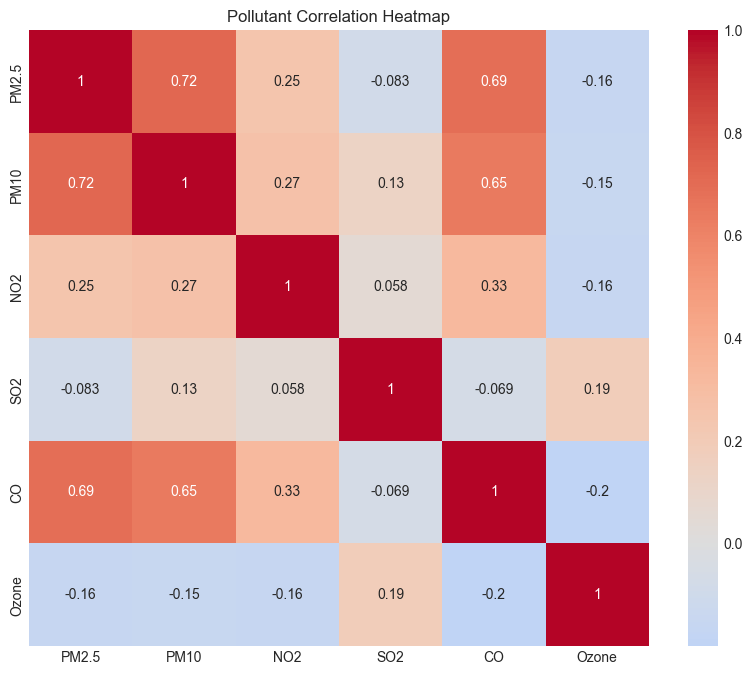

In [54]:
exog_cols = ["PM2.5", "PM10", "NO2", "SO2", "CO", "Ozone"]
df_exog = df[exog_cols].asfreq("D").ffill()
series = df["AQI"].asfreq("D").ffill()
exog_train = df_exog.loc[train.index]
exog_test  = df_exog.loc[test.index]
plt.figure(figsize=(10,8))
sns.heatmap(df_exog.corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Pollutant Correlation Heatmap")
plt.show()

In [56]:
exog_cols = ["PM2.5", "NO2", "CO"]
print("\n SARIMAX SELECTION WITH POLLUTANTS")
print("-" * 60)

seasonal_period = 7   # weekly
D = 1                # from seasonality test

best_aic = np.inf
best_order = None
best_seasonal = None

for p in range(5):
    for q in range(9):
        try:
            model = SARIMAX(
                train,
                exog=exog_train,
                order=(p, d, q),
                seasonal_order=(1, D, 1, seasonal_period),
                enforce_stationarity=False,
                enforce_invertibility=False,
                simple_differencing=True
            )
            fit = model.fit(disp=False)

            if np.isfinite(fit.aic) and fit.aic < best_aic:
                best_aic = fit.aic
                best_order = (p, d, q)
                best_seasonal = (1, D, 1, seasonal_period)

        except Exception:
            continue

# Fallback
if best_order is None:
    print("⚠ All SARIMAX fits failed — using fallback")
    best_order = (1, d, 1)
    best_seasonal = (1, D, 1, seasonal_period)

print(f"✓ Best SARIMAX: {best_order} x {best_seasonal}")


 SARIMAX SELECTION WITH POLLUTANTS
------------------------------------------------------------
✓ Best SARIMAX: (2, 0, 5) x (1, 1, 1, 7)


                                      SARIMAX Results                                      
Dep. Variable:                             DS7.AQI   No. Observations:                 1304
Model:             SARIMAX(2, 0, 5)x(1, 0, [1], 7)   Log Likelihood               -6404.663
Date:                             Sat, 20 Dec 2025   AIC                          12841.325
Time:                                     11:31:23   BIC                          12923.936
Sample:                                 01-08-2021   HQIC                         12872.332
                                      - 08-03-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PM2.5          0.1670      0.008     20.859      0.000       0.151       0.183
PM10           0.4509      

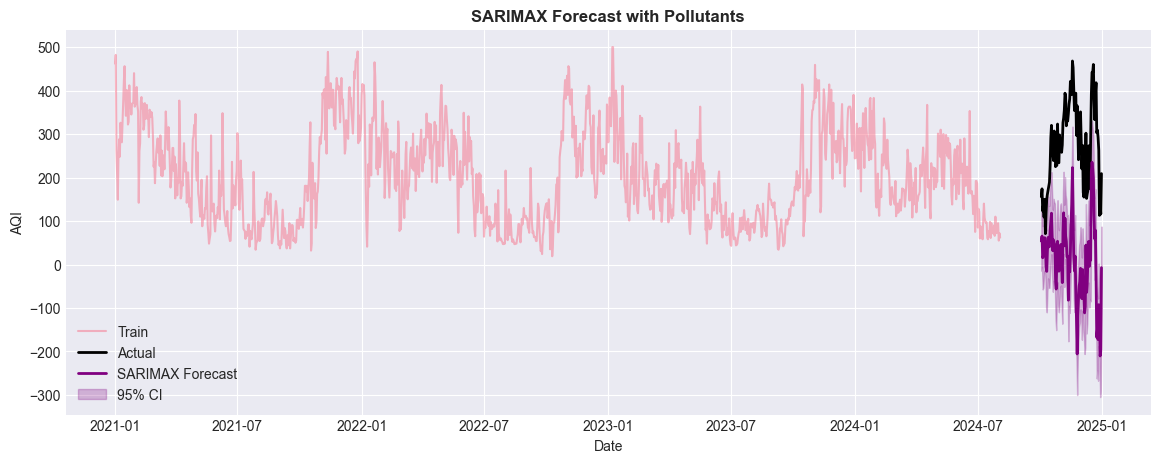

In [57]:
sarimax_model = SARIMAX(
    train,
    exog=exog_train,
    order=best_order,
    seasonal_order=best_seasonal,
    enforce_stationarity=False,
    enforce_invertibility=False,
    simple_differencing=True
).fit(disp=False)

print(sarimax_model.summary())
sarimax_fc = sarimax_model.get_forecast(
    steps=len(test),
    exog=exog_test
)

sarimax_forecast = sarimax_fc.predicted_mean
sarimax_fc = sarimax_model.get_forecast(
    steps=len(test),
    exog=exog_test
)
sarimax_pred = sarimax_fc.predicted_mean.values
sarimax_ci = sarimax_fc.conf_int()

sarimax_forecast.index = test.index
sarimax_ci.index = test.index
plt.figure(figsize=(14,5))

plt.plot(train.index, train, label="Train", alpha=0.5)
plt.plot(test.index, test, label="Actual", color="black", linewidth=2)

plt.plot(
    sarimax_forecast.index,
    sarimax_forecast,
    label="SARIMAX Forecast",
    color="purple",
    linewidth=2
)

plt.fill_between(
    sarimax_ci.index,
    sarimax_ci.iloc[:, 0],
    sarimax_ci.iloc[:, 1],
    color="purple",
    alpha=0.25,
    label="95% CI"
)

plt.title("SARIMAX Forecast with Pollutants", fontweight="bold")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()

In [58]:
sarimax_rmse = np.sqrt(mean_squared_error(test, sarimax_forecast))
sarimax_mae  = mean_absolute_error(test, sarimax_forecast)
sarimax_r2   = r2_score(test, sarimax_forecast)

print("\nSARIMAX Performance:")
print(f"RMSE: {sarimax_rmse:.2f}")
print(f"MAE:  {sarimax_mae:.2f}")
print(f"R²:   {sarimax_r2:.4f}")

coef = sarimax_model.params
conf = sarimax_model.conf_int()

pollutant_effects = pd.DataFrame({
    "Coefficient": coef[exog_cols],
    "Lower CI": conf.loc[exog_cols, 0],
    "Upper CI": conf.loc[exog_cols, 1]
})

print("\nPollutant Effects on AQI:")
print(pollutant_effects.sort_values("Coefficient", ascending=False))


SARIMAX Performance:
RMSE: 285.45
MAE:  266.31
R²:   -7.7436

Pollutant Effects on AQI:
       Coefficient  Lower CI   Upper CI
CO        9.859564  5.838923  13.880205
NO2       0.215680  0.166906   0.264455
PM2.5     0.167039  0.151343   0.182735


#### Results

In [59]:
lstm_pred = scaler.inverse_transform(lstm.predict(X_test)).flatten()
gru_pred  = scaler.inverse_transform(gru.predict(X_test)).flatten()

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000019D57B7A710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 284ms/step


In [60]:
arima_pred  = np.array(arima_forecast).flatten()
sarima_pred = np.array(sarima_pred).flatten()
sarimax_pred = np.array(sarimax_forecast).flatten()

In [61]:
models = {
    "LSTM": lstm_pred,
    "GRU": gru_pred,
    "ARIMA": arima_pred,
    "SARIMA": sarima_pred,
    "SARIMAX": sarimax_pred
}

In [62]:
seq_len = SEQ_LEN

# Common evaluation window (drop first seq_len points)
test_eval = test.iloc[seq_len:].values

# --- Deep Learning models (already length = len(test) - seq_len)
lstm_pred_eval = lstm_pred.flatten()
gru_pred_eval  = gru_pred.flatten()

# --- Statistical models (trim to match DL horizon)
arima_pred_eval   = arima_pred[seq_len:]
sarima_pred_eval  = sarima_pred[seq_len:]
sarimax_pred_eval = sarimax_pred[seq_len:]

# Final safety check
print("Lengths after alignment:")
print("Test:", len(test_eval))
print("LSTM:", len(lstm_pred_eval))
print("GRU:", len(gru_pred_eval))
print("ARIMA:", len(arima_pred_eval))
print("SARIMA:", len(sarima_pred_eval))
print("SARIMAX:", len(sarimax_pred_eval))

Lengths after alignment:
Test: 60
LSTM: 60
GRU: 60
ARIMA: 60
SARIMA: 60
SARIMAX: 60


#### Metrics

In [63]:
def mase(y_true, y_pred, y_train, s=7):
    naive = np.abs(y_train[s:] - y_train[:-s]).mean()
    return np.mean(np.abs(y_true - y_pred)) / naive

models = {
    "LSTM": lstm_pred_eval,
    "GRU": gru_pred_eval,
    "ARIMA": arima_pred_eval,
    "SARIMA": sarima_pred_eval,
    "SARIMAX": sarimax_pred_eval
}

results = []

for name, pred in models.items():
    results.append({
        "Model": name,
        "RMSE": np.sqrt(mean_squared_error(test_eval, pred)),
        "MAE": mean_absolute_error(test_eval, pred),
        "R2": r2_score(test_eval, pred),
        "MASE": mase(test_eval, pred, train.values)
    })

results_df = pd.DataFrame(results).sort_values("RMSE")

print("\nMODEL COMPARISON (ALIGNED HORIZON):")
print(results_df.to_string(index=False))


MODEL COMPARISON (ALIGNED HORIZON):
  Model       RMSE        MAE         R2     MASE
    GRU  58.839603  47.531834   0.600469 0.720489
   LSTM  72.175818  57.150642   0.398835 0.866291
  ARIMA 180.812774 157.353234  -2.772843 2.385165
 SARIMA 264.698402 248.222610  -7.085618 3.762566
SARIMAX 322.530040 310.750802 -11.004689 4.710371


#### Final Forecast


Best 2 model(s): ['GRU' 'LSTM']


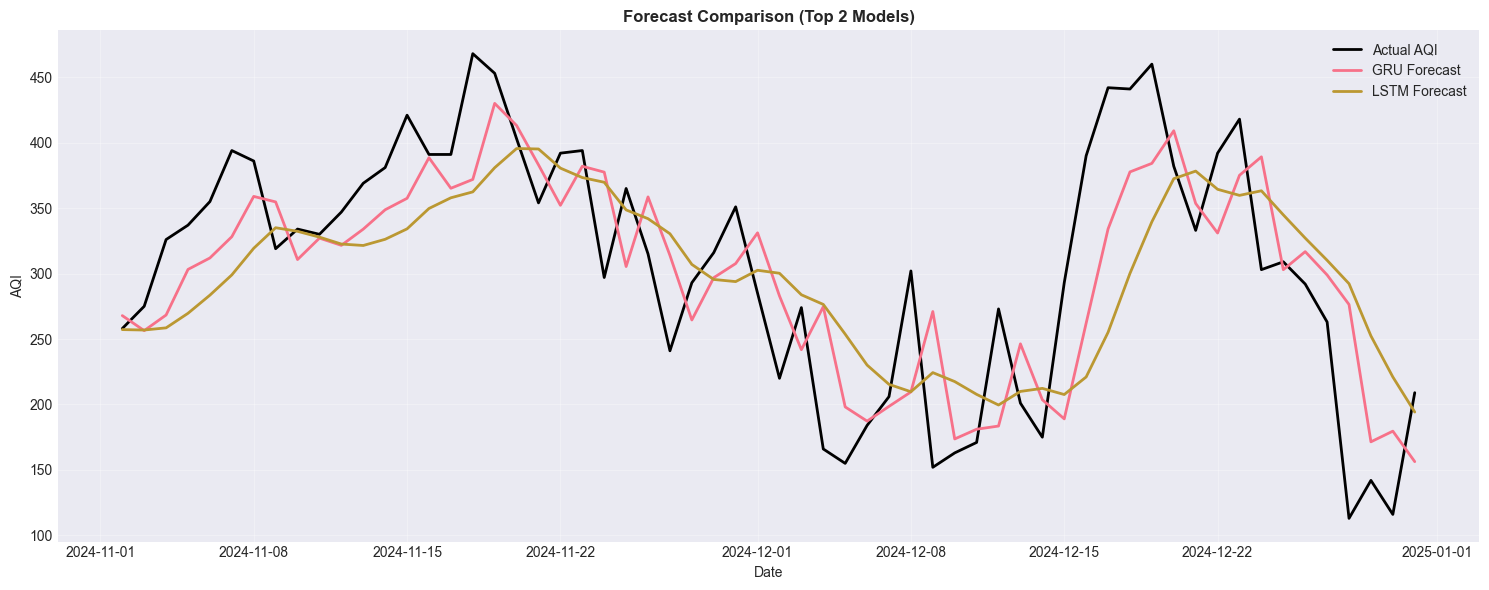

In [64]:
TOP_N = 2

# Get best models
best_models = results_df.head(TOP_N)["Model"].values

print(f"\nBest {TOP_N} model(s):", best_models)

# Create aligned date index
forecast_dates = test.index[seq_len:]

# Map model names to aligned predictions
pred_map = {
    "LSTM": lstm_pred_eval,
    "GRU": gru_pred_eval,
    "ARIMA": arima_pred_eval,
    "SARIMA": sarima_pred_eval,
    "SARIMAX": sarimax_pred_eval
}


plt.figure(figsize=(15, 6))
plt.plot(
    forecast_dates,
    test_eval,
    label="Actual AQI",
    color="black",
    linewidth=2
)

for model_name in best_models:
    plt.plot(
        forecast_dates,
        pred_map[model_name],
        label=f"{model_name} Forecast",
        linewidth=2
    )

plt.title(
    f"Forecast Comparison (Top {TOP_N} Model{'s' if TOP_N > 1 else ''})",
    fontweight="bold"
)
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()